# Applied Machine Learning - Project 2
### Boaz Shvartzman, Ofir Ziv

In [1]:
%matplotlib notebook

In [2]:
import re
import datetime
import collections
import numpy as np
import matplotlib.pyplot as plt

## Part 1

    1.

In [3]:
class DatasetSplitParser(object):
    
    def __init__(self, split_path):
        with open(split_path, 'r')as f:
            file_content = f.read()

        self._ds_by_index = {}
        
        for row in file_content.split('\n')[1:-1]:
            index, ds = row.split(',')
            self._ds_by_index[int(index)] = int(ds)
            
    def get_dataset_by_index(self):
        return self._ds_by_index

    2.

In [4]:
class DatasetsHolder(object):
    
    def __init__(self, sentences_path, datasplit_parser):
        with open(sentences_path, 'r')as f:
            file_content = f.read()
        
        file_content = file_content.decode("ascii", "ignore") # Remove non-ASCII
        file_content = re.sub(r'([^\s\w]|_)+', '', file_content) # Remove non-alphanumeric
        file_content = file_content.lower() # Lowercase
        
        self._trainset = {}
        self._testset = {}
        
        ds_by_index = datasplit_parser.get_dataset_by_index()

        for row in file_content.split('\n')[1:-1]:
            
            index, sentence = row.split('\t')
            index, sentence = int(index), re.sub(r'\b\w{1,2}\b', '', sentence).split()
            
            if len(sentence) < 2:
                continue
                
            if ds_by_index[index] == 1:
                self._trainset[index] = sentence
                
            elif ds_by_index[index] == 2:
                self._testset[index] = sentence

    def get_trainset(self):
        return self._trainset
    
    def get_testset(self):
        return self._testset

## Part 2

    1.

In [50]:
class Hyperparameters(object):
    
    def __init__(self, window_size=1, vector_size=30, negative_words=50, iterations=2000,
                 noise_distribution='unigram', noise_dist_params={'alpha': 1.}, random_seed=1234,
                testset_measure_iterations=100):

        self.window_size = window_size
        self.vector_size = vector_size
        self.negative_words = negative_words
        self.iterations = iterations
        self.noise_distribution = noise_distribution
        self.noise_dist_params = noise_dist_params
        self.random_seed = random_seed
        self.testset_measure_iterations = testset_measure_iterations
        np.random.seed(random_seed)
        
    def __str__(self):
        return '\n'.join(['Window size: {}'.format(self.window_size),
                          'Embedding vector size: {}'.format(self.vector_size),
                          'Negative words: {}'.format(self.negative_words),
                          'Iterations: {}'.format(self.iterations),
                          'Noise distribution: {}'.format(self.noise_distribution),
                          'Random seed: {}'.format(self.random_seed),
                          'Testset measure step size: {}'.format(self.testset_measure_iterations)])

    2. + 3.

In [6]:
class ModelParameters(object):
    
    def __init__(self, hyperparameters):
        self._hyperparameters = hyperparameters
        
    def init(self, trainset):
        self._words = np.unique(sum(trainset.values(), []))
        vector_size = self._hyperparameters.vector_size
        
        def sample():
            vectors = np.random.multivariate_normal(np.zeros(vector_size), np.identity(vector_size) * 1e-2, len(self._words))
            return vectors / np.sqrt(np.sum(np.power(vectors, 2), axis=1)).reshape(-1, 1)

        self.U, self.V = sample(), sample()
        
        return self
        
    def word2index(self, words):
        indices = np.where(np.isin(self._words, words))[0]
        if isinstance(words, collections.Iterable) and not type(words) in [str, unicode]:
            return indices
        else:
            return indices[0]

    def index2word(self, indices):
        return self._words[indices]

    4. + 5.

In [41]:
class unigram_sampler(object):

    def __init__(self, trainset, alpha):
        self.words, self.frequencies = np.unique(sum(trainset.values(), []), return_counts=True)
        factored = np.power(self.frequencies, alpha).astype(np.float64)
        self.probabilities = factored / factored.sum()
        #self._cumsum = np.cumsum(probabilities)
        
    def __call__(self, k):
        #indices = [np.where(self._cumsum > np.random.rand())[0][0] for i in range(k)]
        return np.random.choice(self.words, k, p=self.probabilities)
        #return self.words[indices]

def get_words_sampler(dataset, hyperparams):
    
    if hyperparams.noise_distribution == 'unigram':
        return unigram_sampler(dataset, hyperparams.noise_dist_params['alpha'])

    else:
        raise NotImplemented

    6.

$$ log \left ( \frac{1}{1 + exp(-v_c^Tu_t)} \right ) + \sum_{j=1}^K log \left (1 - \frac{1}{1 + exp(-v_j^Tu_t)} \right ) = log \left ( \sigma(v_c^Tu_t) \right ) + \sum_{j=1}^K log \left (1 - \sigma(v_j^Tu_t) \right )$$

In [8]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def log_prob_context_with_negatives(target_word, context_word, negative_words, model_params):
    U, V = model_params.U, model_params.V
    u_t, v_c = U[target_word].reshape(-1, 1), V[context_word].reshape(-1, 1)
    sig = np.log(sigmoid(v_c.T.dot(u_t)))
    neg = np.sum(np.log(1 - sigmoid(V[negative_words].dot(u_t))))
    
    return (sig + neg).ravel()[0]

## Part 3

    1.

$$ \frac{\partial f}{du_t} = \left (1 - \sigma(v_c^Tu_t) \right )v_c - \sum_{j=1}^K \sigma(v_j^Tu_t)v_j$$

$$ \frac{\partial f}{dv_c} = \left (1 - \sigma(v_c^Tu_t) \right )u_t $$

$$ \frac{\partial f}{dv_j} = - \sigma(v_j^Tu_t) u_t $$

    2.

In [9]:
def log_prob_context_with_negatives_gradient(model_params, target_word, context_word, negative_words):
    U, V = model_params.U, model_params.V
    u_t, v_c = U[target_word].reshape(-1, 1), V[context_word].reshape(-1, 1)
    neg = (1 - sigmoid(v_c.T.dot(u_t)))
    
    dFdu = neg * v_c - np.sum(sigmoid(V[negative_words].dot(u_t)) * V[negative_words], axis=0).reshape(-1, 1)
    dFdv_c = neg * u_t

    dFdv_j = -(sigmoid(V[[negative_words]].dot(u_t))).dot(u_t.T)
    
    return dFdu, dFdv_c, dFdv_j

    3.

In [10]:
class TargetContextSampler(object):
    
    def __init__(self, dataset):
        self.values = dataset.values()
        self.probs = np.array([len(v) for v in self.values]).astype(float)
        self.probs /= self.probs.sum()
        
    def __call__(self, window_size):
        
        w = np.random.choice(self.values, 1, p=self.probs)[0]
        target = np.random.choice(range(len(w)))

        pairs = []

        for i in range(1, window_size + 1):
            if target + i < len(w):
                pairs.append((w[target], w[target + i]))
            if target - i >= 0:
                pairs.append((w[target], w[target - i]))

        return pairs

    4.

In [11]:
def get_target_context_minibatch(sampler, minibatch_size, window_size):
    return [
        sampler(window_size) for i in range(minibatch_size)
    ]

    5.

In [12]:
def get_parameters_update(minibatch_samples, hyperparameters, model_params):

    u_gradients = {}
    c_gradients = {}

    for samples in minibatch_samples:
        target_index = model_params.word2index(samples[0][0])

        for target, context in samples:
            context_index = model_params.word2index(context)
            negative_indeices = model_params.word2index(sample_k_words(hyperparameters.negative_words))
            
            g_t, g_c, g_j = log_prob_context_with_negatives_gradient(model_params, target_index, context_index, 
                                                                     negative_indeices)
            u_gradients[target_index] = u_gradients.get(target_index, 0) + g_t
            c_gradients[context_index] = c_gradients.get(context_index, 0) + g_c
            
            for i, index in enumerate(negative_indeices):
                c_gradients[index] = c_gradients.get(index, 0) + g_j[i].reshape(-1, 1)
                
    return u_gradients, c_gradients

    6.

In [13]:
class SGDParameters(object):
    
    def __init__(self, learning_rate=1e-3, minibatch_size=50, anealing_factor=300):
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.anealing_factor = anealing_factor
        
    def __str__(self):
        return '\n'.join(['Initial learning rate: {}'.format(self.learning_rate),
                          'Minibatch size: {}'.format(self.minibatch_size),
                          'Anealing step size: {}'.format(self.anealing_factor)])

    7.

In [14]:
def LearnParamsUsingSGD(trainset, hyperparameters, sgd_parameters, model_parameters):
    
    U, V = model_parameters.U, model_parameters.V
    learning_rate = sgd_parameters.learning_rate
    errors = []
    sample_target_context = TargetContextSampler(trainset)
    
    for i in range(1, hyperparameters.iterations):
        minibatch = get_target_context_minibatch(sample_target_context, sgd_parameters.minibatch_size, 
                                                 hyperparameters.window_size)
        
        u_gradients, c_gradients = get_parameters_update(minibatch, hyperparameters, model_parameters, U, V)

        if i % sgd_parameters.anealing_factor == 0:
            learning_rate /= 2.0
        
        for index, gradient in u_gradients.items():
            U[index] += (learning_rate * gradient).reshape(-1)

        for index, gradient in c_gradients.items():
            V[index] += (learning_rate * gradient).reshape(-1)
            
        U /= np.sqrt(np.sum(np.power(U, 2), axis=1)).reshape(-1, 1)
        V /= np.sqrt(np.sum(np.power(V, 2), axis=1)).reshape(-1, 1)
            
    return U, V, errors

## Part 4
    1.

In [15]:
def log_prob_full(dataset, hyperparameters, model_params):
    
    def get_next_pair():
        for _, w in dataset.iteritems():
            for target in range(len(w)):
                for i in range(1, hyperparameters.window_size + 1):
                    if target + i < len(w):
                        yield w[target], w[target + i]
                    if target - i >= 0:
                        yield w[target], w[target - i]
    
    total_log_prob = 0
    num_of_pairs = 0
    
    for target_word, context_word in get_next_pair(): 
        negative_words = model_params.word2index(sample_k_words(hyperparameters.negative_words))
        target_index, context_index = model_params.word2index(target_word), model_params.word2index(context_word)
        total_log_prob += log_prob_context_with_negatives(target_index, context_index, 
                                                          negative_words, model_params)
        num_of_pairs += 1
        
    return total_log_prob, num_of_pairs

    2.

In [16]:
def log_prob_minibatch(minibatch_samples, hyperparameters, model_params):
    
    log_prob = 0
    num_of_pairs = 0
    
    for samples in minibatch_samples:
        target_index = model_params.word2index(samples[0][0])
        
        for target, context in samples:
            context_index = model_params.word2index(context)
            negative_indeices = model_params.word2index(sample_k_words(hyperparameters.negative_words))
            log_prob += log_prob_context_with_negatives(target_index, context_index, 
                                                        negative_indeices, model_params)
        num_of_pairs += 1
        
    return log_prob, num_of_pairs

    3. + 4.

In [46]:
def init_live_view():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    return fig, ax

def update_live_view(fig, ax, errors, anealing_factor, smooth_factor=30):
    ax.clear()
    ax.plot(range(len(errors)), errors, color='orange', alpha=0.5)
    ret = np.cumsum(errors, dtype=float)
    ret[smooth_factor:] = ret[smooth_factor:] - ret[:-smooth_factor]
    rolling = ret[smooth_factor - 1:] / smooth_factor
    ax.plot(range(smooth_factor, len(rolling) + smooth_factor), rolling, color='green')
    for line in range(0, len(errors), anealing_factor)[1:]:
        plt.axvline(x=line, color='red')
    fig.canvas.draw()

def LearnParamsUsingSGD(trainset, hyperparameters, sgd_parameters, model_parameters, testset=None):
    
    U, V = model_parameters.U, model_parameters.V
    learning_rate = sgd_parameters.learning_rate
    scores_sequence = []
    fig, ax = init_live_view()
    sample_target_context = TargetContextSampler(trainset)
    trainset_scores, testset_scores = {}, {}
    
    for i in range(1, hyperparameters.iterations):
        minibatch = get_target_context_minibatch(sample_target_context, sgd_parameters.minibatch_size, 
                                                 hyperparameters.window_size)
        u_gradients, c_gradients = get_parameters_update(minibatch, hyperparameters, model_parameters)

        if i % sgd_parameters.anealing_factor == 0:
            learning_rate /= 2.0
        
        for index, gradient in u_gradients.items():
            U[index] += (learning_rate * gradient).reshape(-1)
            U[index] /= np.sqrt(np.sum(np.power(U[index], 2)))

        for index, gradient in c_gradients.items():
            V[index] += (learning_rate * gradient).reshape(-1)
            V[index] /= np.sqrt(np.sum(np.power(V[index], 2)))

        score, samples = log_prob_minibatch(minibatch, hyperparameters, model_parameters)
        trainset_scores[i] = score / samples
        scores_sequence.append(score)
        
        if i % 3 == 0:
            update_live_view(fig, ax, scores_sequence, sgd_parameters.anealing_factor)
                    
        if testset is not None and i % hyperparameters.testset_measure_iterations == 0:
            score, samples = log_prob_full(testset, hyperparameters, model_parameters)
            testset_errors[i] = score / samples
            
        try:
            open('stopFile')
            return trainset_scores, testset_scores
        except IOError:
            continue
            
    return trainset_scores, testset_scores

## Part 5
    1.

In [18]:
def predict_context_words(input_word, hyperparams, model_params):
    target_index = model_params.word2index(input_word)
    negative_indices = model_params.word2index(sample_k_words(hyperparameters.negative_words))
    
    top_10 = np.full(10, -np.inf)
    top_10_words = np.full(10, None)
    
    for context_word in model_params._words:
        
        if context_word == input_word:
            continue
        
        context_index = model_params.word2index(context_word)
        log_prob = log_prob_context_with_negatives(target_index, context_index, 
                                                   negative_indices, model_params)

        smallest = np.argmin(top_10)
        if top_10[smallest] < log_prob:
            top_10[smallest] = log_prob
            top_10_words[smallest] = context_word
            
    return top_10_words[np.argsort(-top_10)]

    2.

In [19]:
def predict_input_words(context_words, hyperparams, model_params):
    
    context_indices = model_params.word2index(context_words)
    negative_indices = model_params.word2index(sample_k_words(hyperparameters.negative_words))
    
    top_10 = np.full(10, -np.inf)
    top_10_words = np.full(10, None)
    
    for target_word in model_params._words:
        
        target_index = model_params.word2index(target_word)
        log_prob = 0
        
        for context_index in context_indices:
            log_prob += log_prob_context_with_negatives(target_index, context_index, 
                                                           negative_indices, model_params)

        smallest = np.argmin(top_10)
        if top_10[smallest] < log_prob:
            top_10[smallest] = log_prob
            top_10_words[smallest] = target_word
            
    return top_10_words[np.argsort(-top_10)]

    3.

In [20]:
def visualize_words(words, model_params, ax=None):
    indices = model_params.word2index(words)
    vectors = model_params.U[indices, :2]
    if ax is None:
        plt.figure()
        plt.scatter(vectors[:, 0], vectors[:, 1])
    else:
        ax.scatter(vectors[:, 0], vectors[:, 1])

    4.

In [21]:
def analogy_solver(word1, word2, word3, model_parameters):
    index1 = model_parameters.word2index(word1)
    index2 = model_parameters.word2index(word2)
    index3 = model_parameters.word2index(word3)
    
    comb = model_parameters.U[index1] - model_parameters.U[index2] + model_parameters.U[index3]
    projections = model_parameters.U.dot(comb)
    top_10 = np.argsort(-projections)[:10]
    return model_parameters.index2word(top_10), projections[top_10]

## Part 6

    1.

In [22]:
split_parser = DatasetSplitParser('datasetSplit.txt')
dataset_holder = DatasetsHolder('datasetSentences.txt', split_parser)

    2.

In [47]:
with open('config.json', 'r') as config_file:
    we_config = json.load(config_file)

hyperparameters = Hyperparameters(**we_config['hyperparameters'])
sgd_parameters = SGDParameters(**we_config['SGD_parameters'])
model_parameters = ModelParameters(hyperparameters).init(dataset_holder.get_trainset())

sample_k_words = get_words_sampler(dataset_holder.get_trainset(), hyperparameters)

    3.

<IPython.core.display.Javascript object>


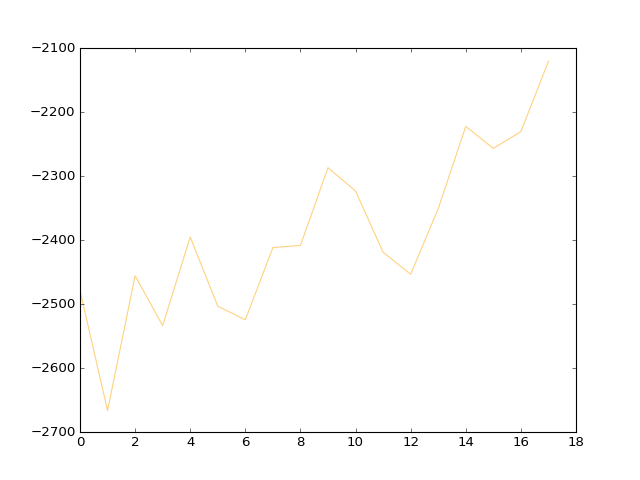

In [48]:
%%prun
time_before = datetime.datetime.now()
trainset_scores, testset_scores = LearnParamsUsingSGD(dataset_holder.get_trainset(), hyperparameters, 
                                                      sgd_parameters, model_parameters, 
                                                      dataset_holder.get_testset())
time_after = datetime.datetime.now()

    4.

In [ ]:
log_likelihood, samples = log_prob_full(dataset_holder.get_trainset(), hyperparameters, model_parameters)
final_trainset_score = log_likelihood / samples
log_likelihood, samples = log_prob_full(dataset_holder.get_testset(), hyperparameters, model_parameters)
final_testset_score = log_likelihood / samples

output_file = open('we_run_sum.txt', 'w')

output_file.write('Hyperparameters\n-------------\n' + str(hyperparameters) + '\n\n')
output_file.write('SGD parameters\n------------------\n' + str(sgd_parameters) + '\n\n')
output_file.write('Mean Log likelihood\n------------------\nTrainset: {}\nTestset: {}\n\n'.format(final_trainset_score,
                                                                                              final_testset_score))
output_file.write('\nTraining time\n--------------\n{}'.format(time_after - time_before))
output_file.close()

## Tests

In [ ]:
hyperparameters = Hyperparameters(vector_size=150, negative_words=10, window_size=5, iterations=500)
model_parameters = ModelParameters(hyperparameters).init(dataset_holder.get_trainset())
sample_k_words = get_words_sampler(dataset_holder.get_trainset(), hyperparameters)
sgd_parameters = SGDParameters(learning_rate=2.0, minibatch_size=50, anealing_factor=1000)

In [ ]:
U, V, trainset_errors, testset_errors = LearnParamsUsingSGD(dataset_holder.get_trainset(), hyperparameters, 
                                                            sgd_parameters, model_parameters)

In [ ]:
predict_context_words('water', hyperparameters, model_parameters)

In [ ]:
predict_input_words(['the', 'wholesome', 'twist', 'interfering', 'during'], hyperparameters, model_parameters)

In [ ]:
predict_input_words(['baby', 'mother', 'father', 'brother', 'sister', 'wife'], hyperparameters, model_parameters)

In [ ]:
visualize_words(['mother', 'father'], model_parameters)
visualize_words(sample_k_words(100), model_parameters, plt.gca())

In [ ]:
analogy_solver('man', 'women', 'king', model_parameters)

In [ ]:
testset_errors